# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** 32

**Author 1 (sciper):** Student Name 1 (xxxxx)  
**Author 2 (sciper):** Student Name 2 (xxxxx)   
**Author 3 (sciper):** Student Name 3 (xxxxx)   

**Release date:** 11.03.2022
**Due date:** 25.03.2022 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.

[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os
#data_base_path = os.path.join(os.pardir, 'data')
data_base_path = os.path.join('/home/iapr', 'data')
data_folder = 'lab-01-data'
data_path = os.path.join(data_base_path, data_folder)
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different
colors. We ask you to create a routine to:

1. Count the number of shapes of each color (5pts).
2. Compute the total area (in pixels) of each color (5pts).

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity
normalization should probably be used.

hint: RGB color space might not be optimal. Consider using HSV or LAB color space.

![RUNOOB 图标](https://img-blog.csdnimg.cn/20181119205543969.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L2ExMzYwMjk1NTIxOA==,size_16,color_FFFFFF,t_70)


### 2.1 Visualization

In [2]:
# import packages
import tarfile
import os
import cv2 as cv
import skimage
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from skimage import filters
from scipy import ndimage
from skimage import morphology


In [3]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames) 
images = skimage.io.concatenate_images(ic) # Height*Weight#RGB  480*640*[RGB]
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


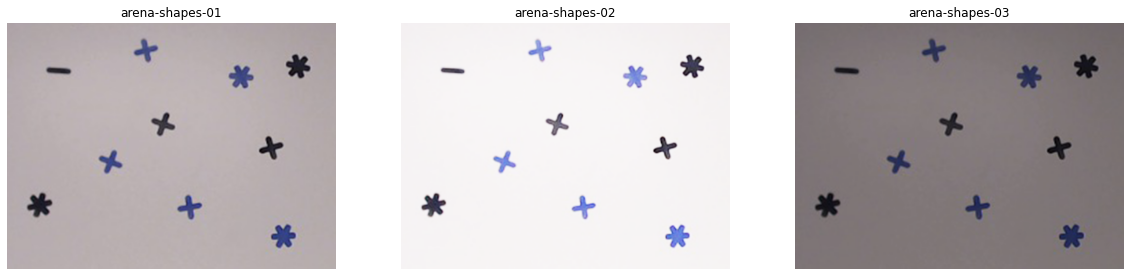

In [4]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(20, 20))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

#### 2.1.1 Histogram
An image is made up of pixels with different grey levels and the distribution of grey levels in an image is an important feature of that image. The histogram of an image depicts the distribution of greyscales in the image and provides a visual representation of how much of the image is occupied by each grey level.

To facilitate the task that follows, the histogram of the image is first plotted here.


In [5]:
# define a function for ploting multiple images
def plotMultipleImages(nrows, ncols, images, titles, type, cmap=False):
    if type=='typ_img':
        fig = plt.figure(figsize=(12,4))
        # fig.set_tight_layout(True)
        fig.subplots_adjust(hspace=0.4, wspace=0.3)
        for i in range(len(titles)):
            ax = fig.add_subplot(nrows, ncols, i+1)
            if cmap==False:                
                ax.imshow(images[i])
            else:
                ax.imshow(images[i], cmap='gray')
            ax.set_title(titles[i])
            ax.axis('off')
    else:
        fig = plt.figure(figsize=(12,4))
        fig.subplots_adjust(hspace=0.4, wspace=0.3)
        for i in range(len(titles)):
            fig.add_subplot(nrows, ncols, i+1)
            if images[i].max() > 1.01:
                plt.hist(images[i].ravel(), 256, [0, 256])
            else:
                plt.hist(images[i].ravel(), 100, [0, 1]) 
            plt.title(titles[i])
            # ax = plt.gca()
            # ax.axes.xaxis.set_ticks([])
            # ax.axes.yaxis.set_ticks([])
    plt.show()


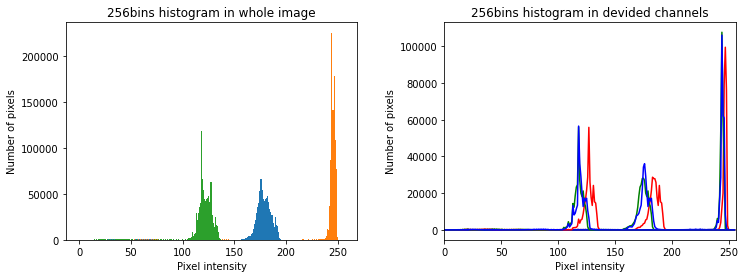

In [6]:
# plot the histogram of the images 
color = ('r','g','b')
# fig = plt.figure(figsize=(20,6))
fig, ax = plt.subplots(1,2,figsize=(12,4))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
plt.subplot(1,2,1)
for im in images:
    plt.hist(im.ravel(), 256, [0, 256]) 
    plt.xlabel('Pixel intensity')
    plt.ylabel('Number of pixels')
    plt.title('256bins histogram in whole image')
# plt.show()
plt.subplot(1,2,2)
i=0
for im in images:
    for i,col in enumerate(color):
        histr = cv.calcHist([im],[i],None,[256],[0,256])
        plt.plot(histr,color = col)
    plt.xlim([0,256])
    plt.xlabel('Pixel intensity')
    plt.ylabel('Number of pixels')
    plt.title('256bins histogram in devided channels')
plt.show()

Each peak in the two subplots represents the distribution of pixels in an independent image data, where the second subplot shows the distribution of pixels in different channels in each image. 
It can be concluded that the RGB channels in the three pictures are relatively concentrated and have linear characteristics, but the peaks of the three pictures are different from each other, which also confirms the different lighting conditions of the three pictures. The next step is to perform histogram equalization and color transformation of space, i.e. to convert RGB to HSV.

### 2.2 Number of shapes of each color (5 pts)

#### 2.2.1 Color Model Conver (RGB->HSV)

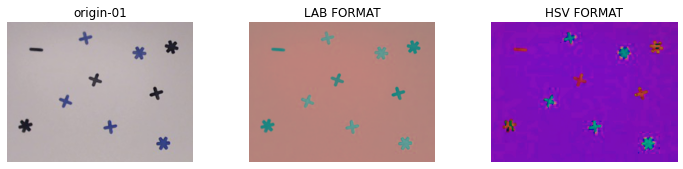

In [7]:
image = cv.imread('/home/iapr/data/lab-01-data/arena-shapes-01.png')[:,:,::-1]
# image = cv.imread('/home/iapr/data/lab-01-data/arena-shapes-01.png')
 
# converting the colourfull image into HSV format image
# using cv2.COLOR_BGR2HSV argument of
# the cvtColor() function of cv2
# in this :
# ist argument is the image matrix
# 2nd argument is the attribute
# image = cv2.GaussianBlur(image, (5, 5), 0)
LAB_img = cv.cvtColor(image,cv.COLOR_BGR2LAB)
HSV_img = cv.cvtColor(image,cv.COLOR_BGR2HSV)
cv.imwrite('result.png', HSV_img)
images=[image,LAB_img,HSV_img]
titles=['origin-01','LAB FORMAT','HSV FORMAT' ]
plotMultipleImages(1, 3, images, titles, 'typ_img')

# # LAB_img = cv2.dilate(thresh, None, iterations=2)
# # HSV_img = cv2.erode(thresh, None, iterations=2)
# HSV_img = cv2.threshold(HSV_img, 10, 255, cv2.THRESH_BINARY)[1]
# LAB_img = cv2.cvtColor(HSV_img,cv2.COLOR_BGR2LAB)
# # plt.imshow(HSV_img)
# LAB_img = cv2.threshold(LAB_img, 200, 255, cv2.THRESH_BINARY)[1]
# plt.imshow(LAB_img)

#### 2.2.2 Intensity Equalization and Normalization
A comparison of the three images shows that they differ significantly in terms of luminance, and in order to make the algorithm more robust, a pixel normalisation strategy is to be used.

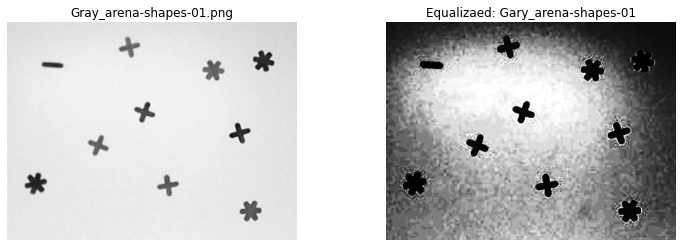

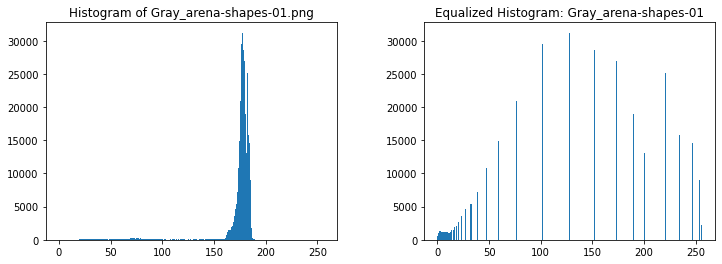

In [8]:
# Equalization
image = cv.imread('/home/iapr/data/lab-01-data/arena-shapes-01.png')
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
dst = cv.equalizeHist(gray)

# plot 
# plt.figure(figsize=(12,12))
# plt.subplot(121)
# plt.imshow(gray, cmap = 'gray')
# plt.subplot(122)
# plt.imshow(dst, cmap = 'gray')
# plt.show()
images = [gray, dst]
titles = ['Gray_arena-shapes-01.png', 'Equalizaed: Gary_arena-shapes-01']
plotMultipleImages(1, 2, images, titles,  type='typ_img', cmap='Ture')

# plot histograms
images = [gray, dst]
titles = ['Histogram of Gray_arena-shapes-01.png', 'Equalized Histogram: Gray_arena-shapes-01']
plotMultipleImages(1, 2, images, titles,  type='typ_hst')

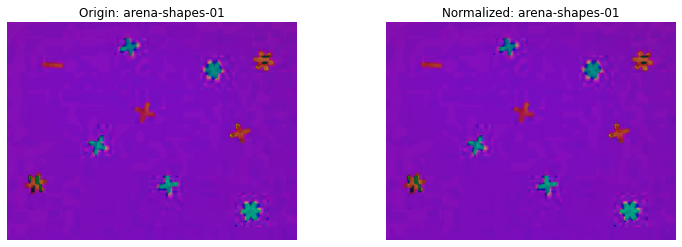

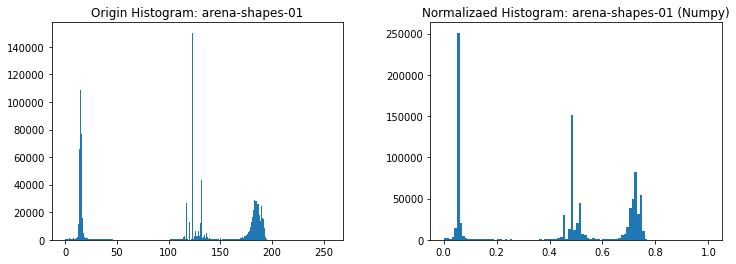

In [9]:
# 1.normalizaition using numpy
image = HSV_img
# image = cv.imread('/home/iapr/data/lab-01-data/arena-shapes-01.png')
image_norm_numpy = (image - np.min(image)) / (np.max(image) - np.min(image))
images = [image, image_norm_numpy]
# plot images
titles = ['Origin: arena-shapes-01', 'Normalized: arena-shapes-01']
plotMultipleImages(1, 2, images, titles, type='typ_img')

# plot histograms
titles = ['Origin Histogram: arena-shapes-01', 'Normalizaed Histogram: arena-shapes-01 (Numpy)']
plotMultipleImages(1, 2, images, titles,  type='typ_hst')

# # 2.normalization using opencv
# h, w, ch = image.shape
# result = np.zeros((h, w, ch), dtype=np.uint8)
# cv.normalize(image, result, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)        
# images = [image, result]
# titles = ['Origin Histogram: arena-shapes-01', 'Normalizaed Histogram: arena-shapes-01 (OpenCV)']
# # plot histograms
# plotMultipleImages(1, 2, images, titles, 'typ_hst')

#### 2.2.4 Object detect and Color Recognition

In [10]:
class ShapeAnalysis:
    def __init__(self):
        # self.shapes = {'triangle': 0, 'rectangle': 0, 'polygons': 0, 'circles': 0}
        self.shapes = {'-': 0, '+': 0, '*': 0}

    def analysis(self, frame):
        """ Image Analysis """
        h, w, ch = frame.shape
        # conatrust a new black image with same size as the original one
        result = np.zeros((h, w, ch), dtype=np.uint8)

        # rgb->binary
        print("\nStart to detect lines...\n")
        # blurred = cv.GaussianBlur(image, (5, 5), 0)
        # Perform image greyscaling and threshold segmentation
        gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        ret, binary = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)
        thresh =cv.Canny(binary, 50, 100)
        # plot
        titles=['input frame','gray image', 'thresh_binary_image']
        images=[frame, gray, binary]
        plotMultipleImages(1, 3, images, titles,  type='typ_img')

        # Contour detect
        # out_binary, contours, hierarchy = cv.findContours(binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        contours, hierarchy = cv.findContours(binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

        # Analysis of the detected contours in turn
        for cnt in range(len(contours)):
            # Fetching and drawing outlines
            cv.drawContours(result, contours, cnt, (0, 255, 0), 2)

            # Contour approaching
            epsilon = 0.01 * cv.arcLength(contours[cnt], True)
            approx = cv.approxPolyDP(contours[cnt], epsilon, True)

            # Analyse the geometry
            corners = len(approx)
            shape_type = ""
            if corners < 10 :
                count = self.shapes['-']
                count = count + 1
                self.shapes['-'] = count
                shape_type = "-"
            if corners <= 17 & corners >= 10 :
                count = self.shapes['+']
                count = count + 1
                self.shapes['+'] = count
                shape_type = "+"
            if corners > 17:
                count = self.shapes['*']
                count = count + 1
                self.shapes['*'] = count
                shape_type = "*"


            # Obtaining the position of the centre of mass
            mm = cv.moments(contours[cnt])
            cx = int(mm['m10'] / mm['m00'])
            cy = int(mm['m01'] / mm['m00'])
            cv.circle(result, (cx, cy), 3, (0, 0, 255), -1)  # 在质心标记

            # Colour analysis
            # 1.BGR Model
            # color = frame[cy][cx]  # 返回原图质心坐标的颜色
            # color_str = "(B_" + str(color[0]) + ", G_" + str(color[1]) + ", R_" + str(color[2]) + ")"
            # 2.HSV Model
            img_hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
            color = img_hsv[cy][cx]
            color_str = "("+ str(color[0]) + ", " + str(color[1]) + "," + str(color[2]) + ")"

            # Area and perimeter analysis
            p = cv.arcLength(contours[cnt], True)
            area = cv.contourArea(contours[cnt])
            file = '/home/iapr/data/lab-01-data/part_2_result.txt'
            with open(file, 'a+') as f:
                f.write("Object：%2d, Shape: %s Corners：%2d, P: %.3f, Area: %.3f Color: %s " % (cnt + 1,shape_type, corners,  p, area, color_str) + '\n')  # 加\n换行显示
            print("Object:%2d, Shape: %s, Area: %8.3f, Color: %s " % (cnt + 1,shape_type, area, color_str))
            # print("Shape: %s, Area: %8.3f, HSV: %s " % (shape_type, area, color_str))
        plt.figure(figsize=(6,6))
        plt.imshow(self.draw_text_info(result)[:, :, ::-1])
        plt.show()
        cv.imwrite('/home/iapr/data/lab-01-data/part_2-result.png', self.draw_text_info(result))
        return self.shapes

    def draw_text_info(self, image):
        """ Object Counting """
        c1 = self.shapes['-']
        c2 = self.shapes['+']
        c3 = self.shapes['*']
        # c4 = self.shapes['circles']
        cv.putText(image, "-: " + str(c1), (10, 20), cv.FONT_HERSHEY_PLAIN, 1.2, (255, 0, 0), 1)
        cv.putText(image, "+: " + str(c2), (10, 40), cv.FONT_HERSHEY_PLAIN, 1.2, (255, 0, 0), 1)
        cv.putText(image, "*: " + str(c3), (10, 60), cv.FONT_HERSHEY_PLAIN, 1.2, (255, 0, 0), 1)
        return image
    

The visualisation process, due to differences between the CV library and the PLT library in terms of the channels used to read and write the images, therefore the overall tone of the display is somewhat affected, but does not affect the analysis as a whole.


Start to detect lines...



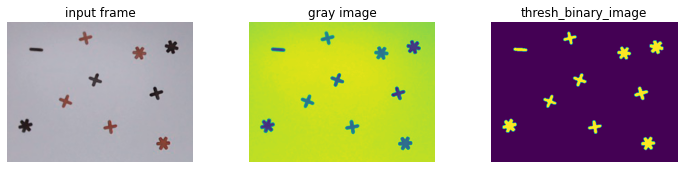

Object: 1, Shape: *, Area: 1231.500, Color: (117, 151,135) 
Object: 2, Shape: +, Area:  789.500, Color: (117, 145,128) 
Object: 3, Shape: *, Area: 1299.500, Color: (120, 78,39) 
Object: 4, Shape: +, Area:  758.000, Color: (115, 155,145) 
Object: 5, Shape: +, Area:  874.500, Color: (126, 58,44) 
Object: 6, Shape: +, Area:  815.500, Color: (135, 25,62) 
Object: 7, Shape: -, Area:  432.500, Color: (133, 45,40) 
Object: 8, Shape: *, Area: 1141.500, Color: (116, 141,136) 
Object: 9, Shape: *, Area: 1275.500, Color: (122, 85,48) 
Object:10, Shape: +, Area:  731.500, Color: (116, 133,125) 


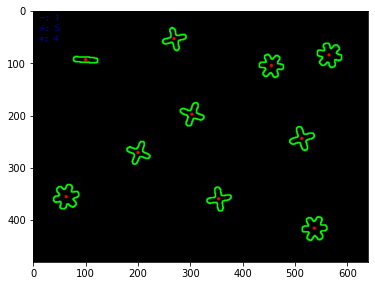

{'-': 1, '+': 5, '*': 4}

In [11]:

src = cv.imread('/home/iapr/data/lab-01-data/arena-shapes-01.png')
file = '/home/iapr/data/lab-01-data/test_result.txt'
with open(file, 'a+') as f:
    f.write("\nNew Test" + '\n')  
image_analyze = ShapeAnalysis()
image_analyze.analysis(src)

#### Concolsuion
* Object：1, Shape: *, Area: 1231.500, Color: (117, 151,135)
* Object：2, Shape: +, Area:  789.500, Color: (117, 145,128) 
* Object：3, Shape: *, Area: 1299.500, Color: (120, 78,39) 
* Object：4, Shape: +, Area:  758.000, Color: (115, 155,145) 
* Object：5, Shape: +, Area:  874.500, Color: (126, 58,44) 
* Object：6, Shape: +, Area:  815.500, Color: (135, 25,62) 
* Object：7, Shape: -, Area:  432.500, Color: (133, 45,40) 
* Object：8, Shape: *, Area: 1141.500, Color: (116, 141,136) 
* Object：9, Shape: *, Area: 1275.500, Color: (122, 85,48) 
* Object:10, Shape: +, Area:  731.500, Color: (116, 133,125) 

### 2.3 Total area (in pixels) of each color (5 pts)

The two colours are first distinguished and then the number of pixels is counted on the different colours using the region growing algorithm.

#### 2.1 Different colour extraction

In [14]:
import cv2 as cv
import numpy as np
import collections
from matplotlib import pyplot as plt

In [32]:
def getColorList():
    dict = collections.defaultdict(list)

    # black
    lower_black = np.array([0, 0, 0])
    upper_black = np.array([180, 255, 46])
    color_list = []
    color_list.append(lower_black)
    color_list.append(upper_black)
    dict['black'] = color_list

    # gray
    # lower_gray = np.array([0, 0, 46])
    # upper_gray = np.array([180, 43, 220])
    # color_list = []
    # color_list.append(lower_gray)
    # color_list.append(upper_gray)
    # dict['gray']=color_list

    # white
    # lower_white = np.array([0, 0, 221])
    # upper_white = np.array([180, 30, 255])
    # color_list = []
    # color_list.append(lower_white)
    # color_list.append(upper_white)
    # dict['white'] = color_list

    # red
    lower_red = np.array([156, 43, 46])
    upper_red = np.array([180, 255, 255])
    color_list = []
    color_list.append(lower_red)
    color_list.append(upper_red)
    dict['red'] = color_list


    # orange
    # lower_orange = np.array([11, 43, 46])
    # upper_orange = np.array([25, 255, 255])
    # color_list = []
    # color_list.append(lower_orange)
    # color_list.append(upper_orange)
    # dict['orange'] = color_list

    # # yellow
    # lower_yellow = np.array([26, 43, 46])
    # upper_yellow = np.array([34, 255, 255])
    # color_list = []
    # color_list.append(lower_yellow)
    # color_list.append(upper_yellow)
    # dict['yellow'] = color_list

    # green
    lower_green = np.array([35, 43, 46])
    upper_green = np.array([77, 255, 255])
    color_list = []
    color_list.append(lower_green)
    color_list.append(upper_green)
    dict['green'] = color_list

    # # cyan
    # lower_cyan = np.array([78, 43, 46])
    # upper_cyan = np.array([99, 255, 255])
    # color_list = []
    # color_list.append(lower_cyan)
    # color_list.append(upper_cyan)
    # dict['cyan'] = color_list

    # blue
    lower_blue = np.array([100, 43, 46])
    upper_blue = np.array([124, 255, 255])
    color_list = []
    color_list.append(lower_blue)
    color_list.append(upper_blue)
    dict['blue'] = color_list

    # purple
    # lower_purple = np.array([125, 43, 46])
    # upper_purple = np.array([155, 255, 255])
    # color_list = []
    # color_list.append(lower_purple)
    # color_list.append(upper_purple)
    # dict['purple'] = color_list

    return dict


# color_hsv = {
#         # HSV，H表示色调（度数表示0-180），S表示饱和度（取值0-255），V表示亮度（取值0-255）
#         "black": [np.array([11, 115, 70]), np.array([34, 255, 245])],
#         "gray": [np.array([35, 115, 70]), np.array([77, 255, 245])],
#         "blue": [np.array([100, 115, 70]), np.array([124, 255, 245])],
#         "lightblue": [np.array([78, 115, 70]), np.array([99, 255, 245])],
#         "purple": [np.array([125, 115, 70]), np.array([155, 255, 245])],
#         "red": [np.array([156, 115, 70]), np.array([179, 255, 245])],
#     }


In [90]:
# Image mask
def get_color(frame):
    print('Color Mask---')
    hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
    # hsv = cv.cvtColor(frame, cv.COLOR_RGB2HSV)
    # print(hsv)
    # color_dict = color_hsv
    color_dict = getColorList()
    plt.figure(figsize=(20,12))
    for i,d in enumerate(color_dict):
        # Img_Name = "img/" + str(d) + ".jpg"
        mask = cv.inRange(hsv, color_dict[d][0], color_dict[d][1])
        mask = cv.erode(mask, None, iterations=1)
        # cv.imwrite(Img_Name, mask)
        binary = cv.threshold(mask, 127, 255, cv.THRESH_BINARY)[1]
        binary = cv.dilate(binary, None, iterations=2)
        # cv.imshow(d, binary)
        # cv.waitKey(0)
        # cv.destroyAllWindows()
        plt.subplot(1,4,i+1)
        plt.title('object in color: '+ d)
        plt.imshow(binary)
        # cnts, hiera = cv.findContours(binary.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    plt.show()

Color Mask---


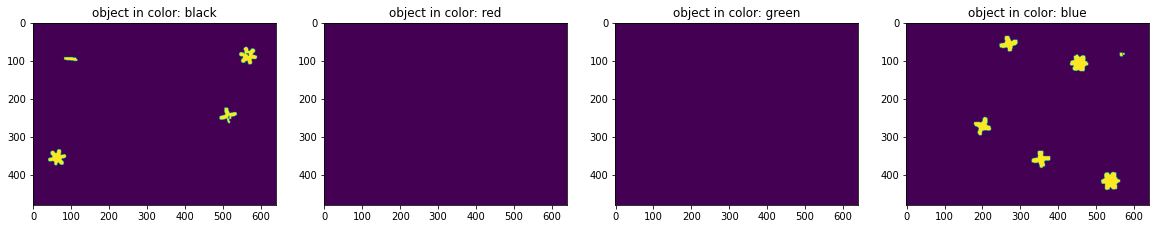

In [91]:
filename = '/home/iapr/data/lab-01-data/arena-shapes-01.png'
frame = cv.imread(filename)
get_color(frame)